In [127]:
# Python code for clustering customers based on order data retrieved from a 
# MySQL database. The code connects to the database, fetches order data, and 
# uses KMeans clustering to group customers.

import pandas as pd
import mysql.connector
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


# Ustawienia połączenia z bazą danych Oracle
username = "root"
password = "admin"
host = "localhost"
database = "Cleaning_Company"

# Establish a connection to the MySQL database
connection = mysql.connector.connect(user=username, password=password, host=host, database=database)
query = f"SELECT * FROM orders_with_costs;"
orders_df = pd.read_sql(query, connection)

orders_df.head()

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_9748\2991401156.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql(query, connection)


,order_id,cleaning_variant_fk,cleaning_duration,is_inside_cleaning,is_outside_cleaning,travel_distance,salesman_id_fk,customer_id_fk,cleaning_address,cleaning_date,variant_name,variant_standard_cost_per_hour,variant_outside_cost_per_hour,cleaning_cost_without_travel,travel_cost,total_cost,worker_first_name,worker_last_name,customer_first_name,customer_last_name
0,464,100000,4,True,False,17,50,1,"05548 Kara Loop\nFarleyville, NV 26048",2024-02-29,Fast,55,90,220,37.4,257.4,Eric,Zhang,Samuel,Doyle
1,2530,100000,8,True,False,73,37,1,"9130 Jones Hills Apt. 053\nEast Candiceville, ...",2024-02-20,Fast,55,90,440,160.6,600.6,Mark,Foster,Samuel,Doyle
2,3487,100100,11,True,False,1,41,1,"75122 Kenneth Brook\nNorth Kimberlymouth, AR 9...",2024-02-04,Standard,75,120,825,2.2,827.2,Stephanie,Prince,Samuel,Doyle
3,4860,100000,3,True,False,39,50,1,"1667 David Port\nNew Anthony, GA 77889",2024-02-09,Fast,55,90,165,85.8,250.8,Eric,Zhang,Samuel,Doyle
4,7945,100000,6,True,False,77,17,1,Unit 4584 Box 6917\nDPO AA 30972,2024-03-03,Fast,55,90,330,169.4,499.4,Lisa,Goodwin,Samuel,Doyle


In [130]:
orders_by_customer = pd.pivot_table(orders_df, "order_id", "customer_id_fk", "variant_name", aggfunc="count")
orders_by_customer

variant_name,Fast,Premium,Silver,Standard,VIP
customer_id_fk,,,,,
1,6.0,1.0,NaN,2.0,NaN
2,2.0,NaN,1.0,3.0,NaN
3,4.0,1.0,2.0,8.0,1.0
4,NaN,NaN,4.0,4.0,1.0
5,6.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...
1084,7.0,2.0,NaN,6.0,NaN
1085,6.0,1.0,3.0,4.0,NaN
1086,4.0,2.0,3.0,5.0,NaN


In [137]:
scaler = StandardScaler()
standarized_orders_by_customers = orders_by_customer.copy()

In [138]:
for column in standarized_orders_by_customers:
    standarized_orders_by_customers[column] = scaler.fit_transform(pd.DataFrame(standarized_orders_by_customers[column]).fillna(0))

standarized_orders_by_customers

variant_name,Fast,Premium,Silver,Standard,VIP
customer_id_fk,,,,,
1,0.460851,-0.006461,-1.247792,-1.321162,-0.495280
2,-1.306217,-1.010644,-0.417965,-0.869568,-0.495280
3,-0.422683,-0.006461,0.411863,1.388403,1.585277
4,-2.189751,-1.010644,2.071518,-0.417974,1.585277
5,0.460851,0.997722,-1.247792,-2.224351,-0.495280
...,...,...,...,...,...
1084,0.902618,0.997722,-1.247792,0.485215,-0.495280
1085,0.460851,-0.006461,1.241691,-0.417974,-0.495280
1086,-0.422683,0.997722,1.241691,0.033621,-0.495280


In [139]:
def elbow_plot(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

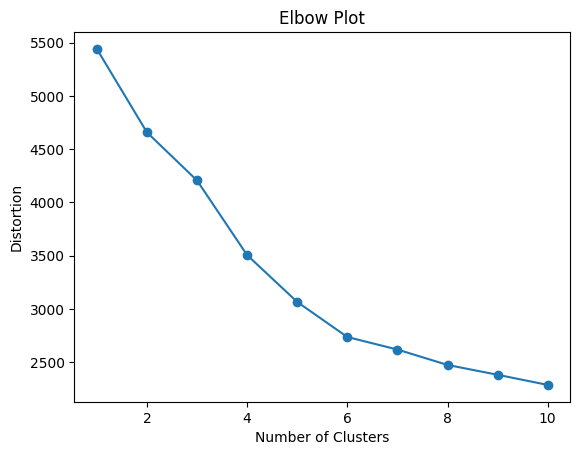

In [140]:
elbow_plot(standarized_orders_by_customers)

In [141]:
# Wybierz odpowiednie cechy dla algorytmu klastrowania
features = standarized_orders_by_customers[list(standarized_orders_by_customers.columns)]

# Określ liczbę klastrów
num_clusters = 6

# Utwórz instancję modelu KMeans
kmeans = KMeans(n_clusters=num_clusters)

# Wytrenuj model na danych
kmeans.fit(features)

# Przypisz etykiety klastrów do danych
labels = kmeans.labels_

# Dodaj kolumnę z etykietami do danych
standarized_orders_by_customers['cluster_label'] = labels

# Wyświetl wyniki
standarized_orders_by_customers.head()

variant_name,Fast,Premium,Silver,Standard,VIP,cluster_label
customer_id_fk,,,,,,
1,0.460851,-0.006461,-1.247792,-1.321162,-0.495280,5
2,-1.306217,-1.010644,-0.417965,-0.869568,-0.495280,3
3,-0.422683,-0.006461,0.411863,1.388403,1.585277,4
4,-2.189751,-1.010644,2.071518,-0.417974,1.585277,1
5,0.460851,0.997722,-1.247792,-2.224351,-0.495280,2


In [143]:
clusters_means = standarized_orders_by_customers.groupby("cluster_label").mean()
clusters_means

variant_name,Fast,Premium,Silver,Standard,VIP
cluster_label,,,,,
0,-0.167287,-0.168594,-0.171610,1.418980,-0.376081
1,-0.123743,0.008640,1.815707,-0.221038,-0.260630
2,-0.248827,1.626146,-0.268060,-0.304347,-0.253667
3,-0.533968,-0.635033,-0.360954,-0.386948,-0.495280
4,0.016696,-0.201869,-0.081548,-0.193397,1.866434
5,1.391031,-0.106255,-0.356114,-0.364680,-0.430666


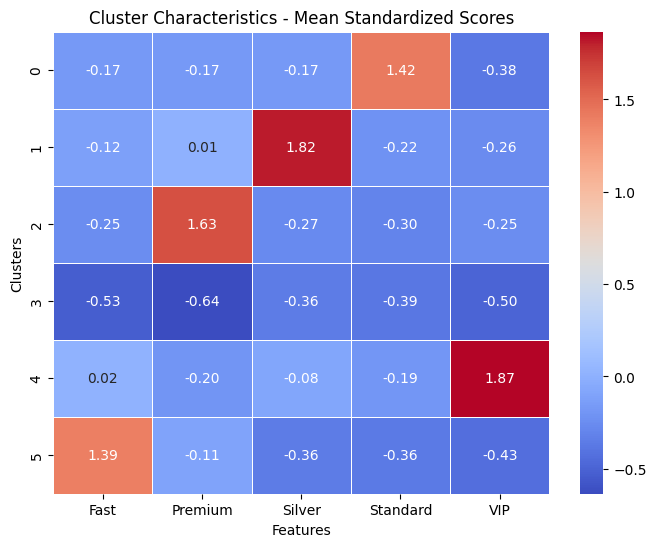

In [144]:
# Plotting
plt.figure(figsize=(8,6), facecolor='white')
sns.heatmap(clusters_means, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.6)
plt.title('Cluster Characteristics - Mean Standardized Scores')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

In [ ]:
customers_type = {
    0 : "standard",
    1 : "silver",
    2 : "premium",
    3 : "undefined",
    4 : "vip",
    5 : "fast"
}